In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit_ibm_runtime.fake_provider import FakeFez # Simulador de ruido realista
import matplotlib.pyplot as plt
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


n_qubits = 6
qc = QuantumCircuit(n_qubits)

# Ponemos q0 y q1 en estado |1>
qc.x(0)
qc.barrier()
qc.x(1)
qc.barrier()

# Toffolis encadenadas
qc.ccx(0, 1, 2) 
qc.barrier()
qc.ccx(1, 2, 3)
qc.barrier()
qc.ccx(2, 3, 4)
qc.barrier()
qc.ccx(3, 4, 5)

qc.measure_all()

        ┌───┐ ░       ░       ░       ░       ░       ░ ┌─┐               
   q_0: ┤ X ├─░───────░───■───░───────░───────░───────░─┤M├───────────────
        └───┘ ░ ┌───┐ ░   │   ░       ░       ░       ░ └╥┘┌─┐            
   q_1: ──────░─┤ X ├─░───■───░───■───░───────░───────░──╫─┤M├────────────
              ░ └───┘ ░ ┌─┴─┐ ░   │   ░       ░       ░  ║ └╥┘┌─┐         
   q_2: ──────░───────░─┤ X ├─░───■───░───■───░───────░──╫──╫─┤M├─────────
              ░       ░ └───┘ ░ ┌─┴─┐ ░   │   ░       ░  ║  ║ └╥┘┌─┐      
   q_3: ──────░───────░───────░─┤ X ├─░───■───░───■───░──╫──╫──╫─┤M├──────
              ░       ░       ░ └───┘ ░ ┌─┴─┐ ░   │   ░  ║  ║  ║ └╥┘┌─┐   
   q_4: ──────░───────░───────░───────░─┤ X ├─░───■───░──╫──╫──╫──╫─┤M├───
              ░       ░       ░       ░ └───┘ ░ ┌─┴─┐ ░  ║  ║  ║  ║ └╥┘┌─┐
   q_5: ──────░───────░───────░───────░───────░─┤ X ├─░──╫──╫──╫──╫──╫─┤M├
              ░       ░       ░       ░       ░ └───┘ ░  ║  ║  ║  ║  ║ └╥┘
meas: 6/═════════════════

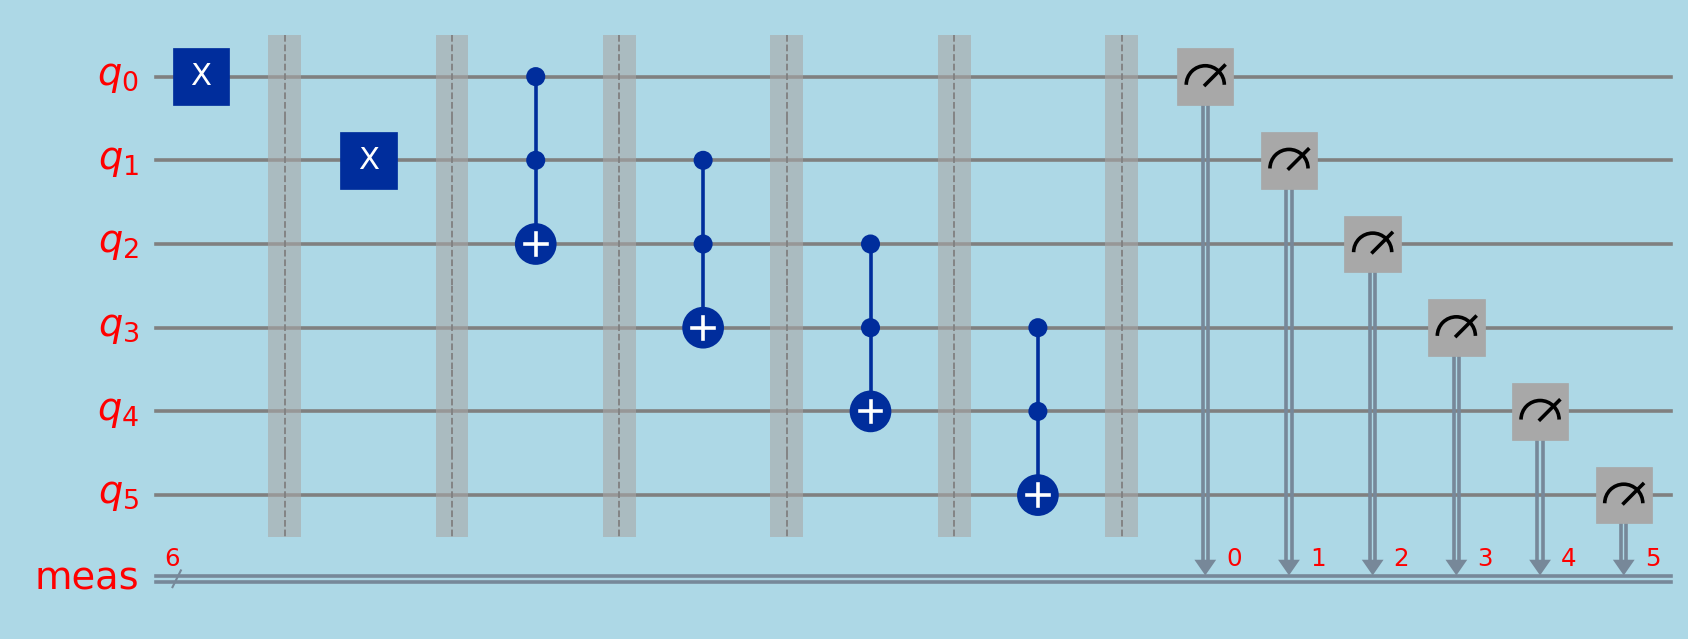

In [2]:
print(qc.draw(output='text'))

estilo = {
    'backgroundcolor': '#ADD8E6', 
    'linecolor': '#808080',       
    'textcolor': '#FF0000',       
    'barrier': '#808080',         
    'fontsize': 17,
}

qc.draw(output="mpl", style=estilo, scale=1.3)

In [3]:
simulator = AerSimulator()
job_ideal = simulator.run(transpile(qc, simulator), shots=2048)
counts_ideal = job_ideal.result().get_counts()

backend_noisy = FakeFez()
qc_transpiled = transpile(qc, backend_noisy, optimization_level=3)
job_noisy = backend_noisy.run(qc_transpiled, shots=2048)
counts_noisy = job_noisy.result().get_counts()

service = QiskitRuntimeService()
print("\nBuscando el ordenador cuántico real menos ocupado...")
backend = service.least_busy(operational=True, simulator=False)
print(f"Ejecutando en: {backend.name}")


Buscando el ordenador cuántico real menos ocupado...
Ejecutando en: ibm_torino


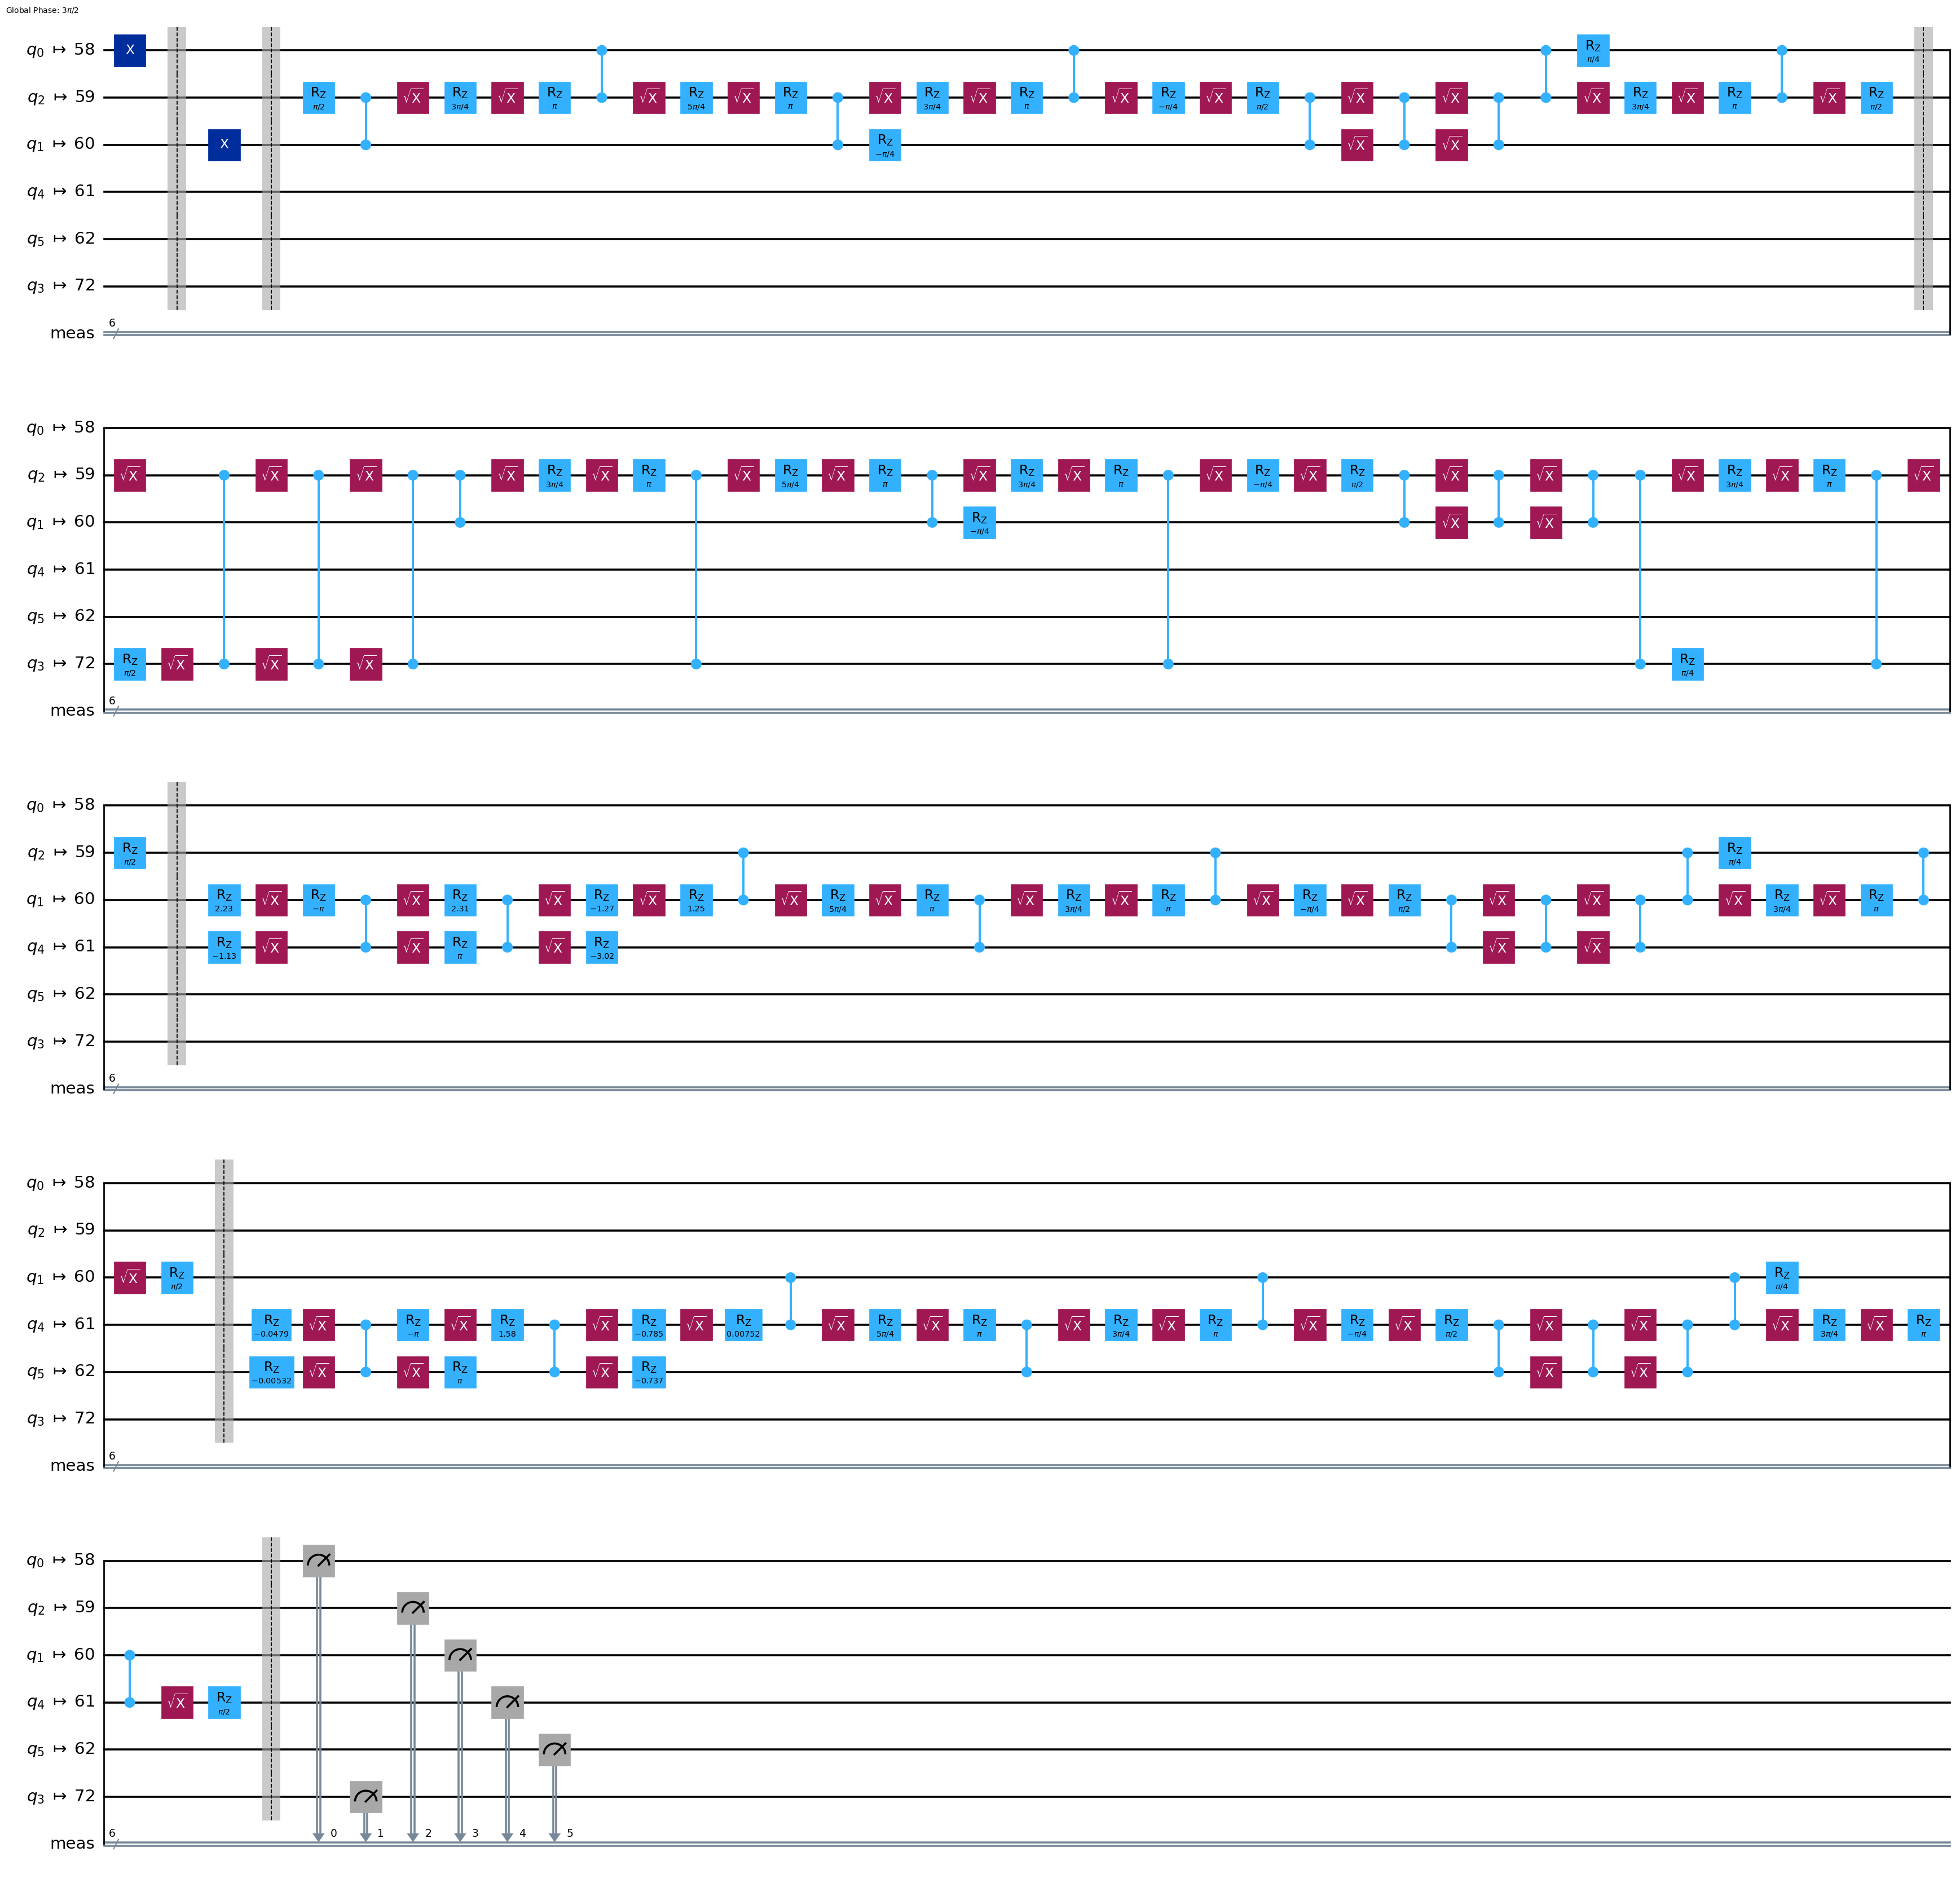

In [4]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuit = pm.run(qc)

isa_circuit.draw(output="mpl", scale=1.3, fold=39)

In [5]:
def get_prob_per_qubit(counts, n):
    probs = [0.0] * n
    total_shots = sum(counts.values())
    for bitstring, count in counts.items():
        # ble damos la vuelta a los bits, porque en IBM vienen desde el más significativo al menos significativo.
        reversed_bits = bitstring[::-1] 
        for i in range(n):
            if reversed_bits[i] == '1':
                probs[i] += count
    return [p / total_shots for p in probs]

probs_ideal = get_prob_per_qubit(counts_ideal, n_qubits)
probs_noisy = get_prob_per_qubit(counts_noisy, n_qubits)

sampler = Sampler(backend)
job_id = None
job_id = 'd50lil6aec6c738tj3n0' #Lo copiamos a mano una vez ejecutado para no estar creando nuevas ejecuciones
if job_id == None:
    job = sampler.run([isa_circuit])
    job_id = job.job_id()
    print(f"Trabajo enviado. ID del trabajo: {job.job_id()}")
    print("Esperando resultados (esto puede tardar unos minutos dependiendo de la cola)...")
else:
    job = service.job(job_id)
    print(f"Cargando trabajo ya ejecutado. ID del trabajo: {job.job_id()}")
    print("Esperando resultados (esto puede tardar unos minutos dependiendo de la cola)...")

print(job)
result = job.result()
counts_real = result[0].data.meas.get_counts()
probs_real = get_prob_per_qubit(counts_real, n_qubits)

Cargando trabajo ya ejecutado. ID del trabajo: d50lil6aec6c738tj3n0
Esperando resultados (esto puede tardar unos minutos dependiendo de la cola)...
<RuntimeJobV2('d50lil6aec6c738tj3n0', 'sampler')>


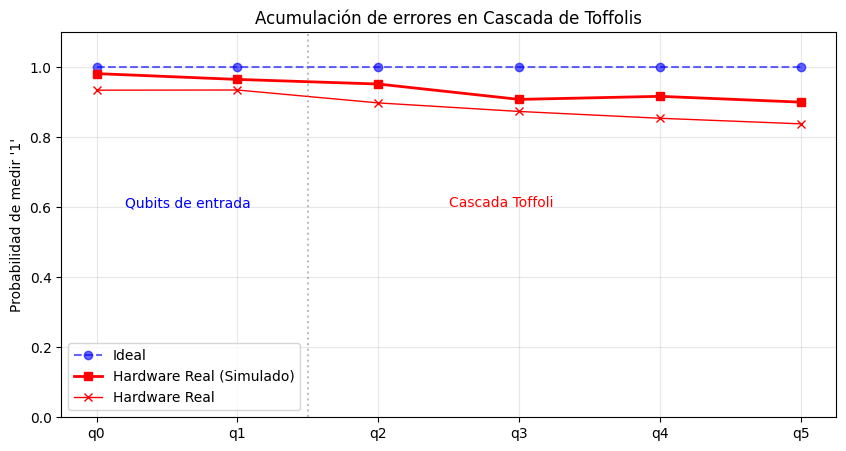

In [6]:
# --- 5. Visualización ---
qubit_labels = [f'q{i}' for i in range(n_qubits)]

plt.figure(figsize=(10, 5))
plt.plot(qubit_labels, probs_ideal, 'b--o', label='Ideal', alpha=0.6)
plt.plot(qubit_labels, probs_noisy, 'r-s', label='Hardware Real (Simulado)', linewidth=2)
plt.plot(qubit_labels, probs_real, 'r-x', label='Hardware Real', linewidth=1)


# Decoración para entender mejor
plt.axvline(x=1.5, color='gray', linestyle=':', alpha=0.5)
plt.text(0.2, 0.6, 'Qubits de entrada', color='blue')
plt.text(2.5, 0.6, 'Cascada Toffoli', color='red')


plt.title('Acumulación de errores en Cascada de Toffolis')
plt.ylabel("Probabilidad de medir '1'")
plt.ylim(0, 1.1)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
